In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt


Image shape: (720, 720, 3)


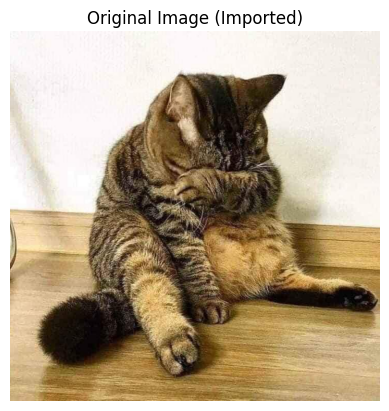

In [2]:
img = plt.imread("/content/drive/MyDrive/meme/15.jpg")
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

h, w, c = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image (Imported)")
plt.axis("off")
plt.show()

Execution time (2D blocks): 1.537123 seconds


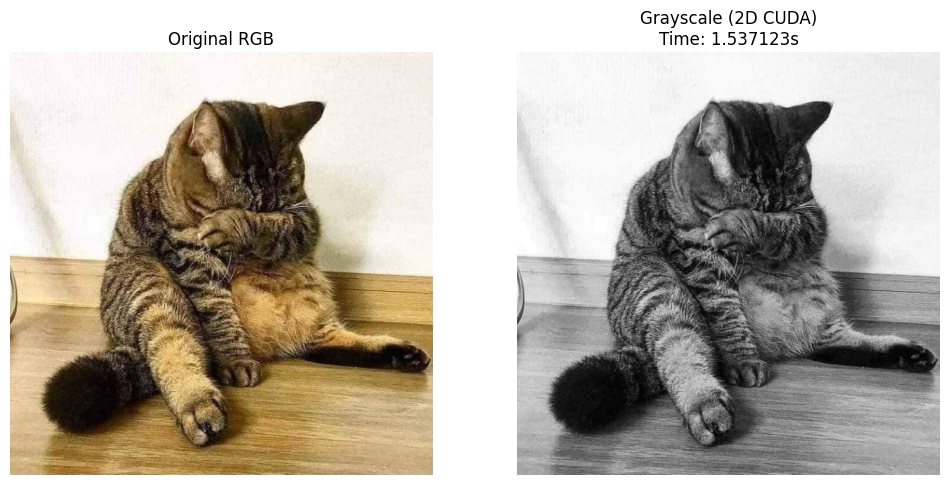

In [3]:
h, w, c = img.shape
img_u8 = (img * 255).astype(np.uint8)
d_src = cuda.to_device(img_u8)
d_gray = cuda.device_array((h, w), dtype=np.uint8)


@cuda.jit
def grayscale(src, dst):
    x, y = cuda.grid(2)
    if x < src.shape[0] and y < src.shape[1]:
        r = src[x, y, 0]
        g = src[x, y, 1]
        b = src[x, y, 2]
        dst[x, y] = (r + g + b) // 3


threadsperblock = (8, 8)
blockspergrid_x = (h + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (w + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)


start = time.time()
grayscale[blockspergrid, threadsperblock](d_src, d_gray)
cuda.synchronize()
end = time.time()

print(f"Execution time (2D blocks): {end - start:.6f} seconds")


gray_result = d_gray.copy_to_host()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_result, cmap='gray')
ax2.set_title(f"Grayscale (2D CUDA)\nTime: {end - start:.6f}s")
ax2.axis("off")

plt.show()


In [ ]:
block_sizes = [(8, 8), (16, 16), (32, 32)]
results = []

for tp in block_sizes:
    threadsperblock = tp
    blockspergrid_x = (h + tp[0] - 1) // tp[0]
    blockspergrid_y = (w + tp[1] - 1) // tp[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time.time()
    grayscale[blockspergrid, threadsperblock](d_src, d_gray)
    cuda.synchronize()
    end = time.time()

    exec_time = end - start
    results.append((tp, exec_time))



print(f"{'Threads per block':<20} | {'Execution Time (s)':>20}")
print("-" * 45)
for tp, t in results:
    print(f"{str(tp):<20} | {t:>20.6f}")


Threads per block    |   Execution Time (s)
---------------------------------------------
(8, 8)               |             0.000706
(16, 16)             |             0.000241
(32, 32)             |             0.000247


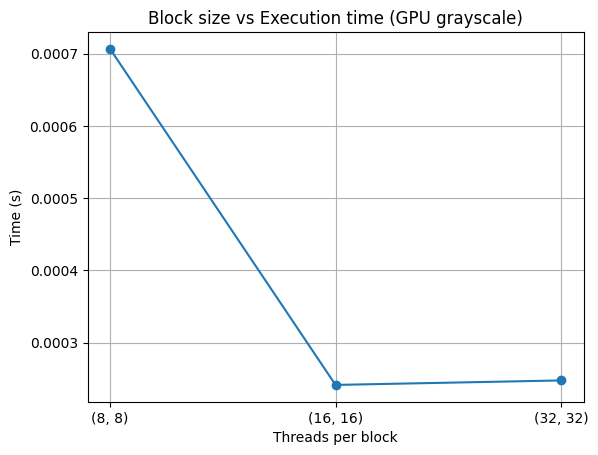

In [ ]:
sizes = [f"{tp}" for tp, _ in results]
times = [t for _, t in results]

plt.plot(sizes, times, marker='o')
plt.title("Block size vs Execution time (GPU grayscale)")
plt.xlabel("Threads per block")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("blocksize_vs_time.png", dpi=150)
plt.show()


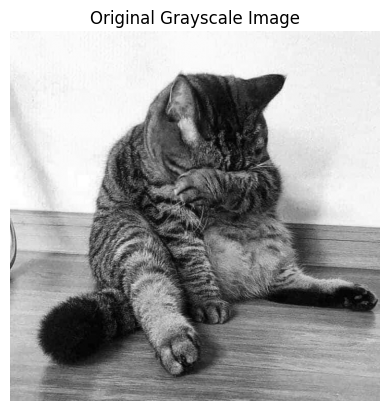

Gaussian Blur (no shared): 0.159518 seconds
Gaussian Blur (shared): 0.196544 seconds
Speedup: 0.81x


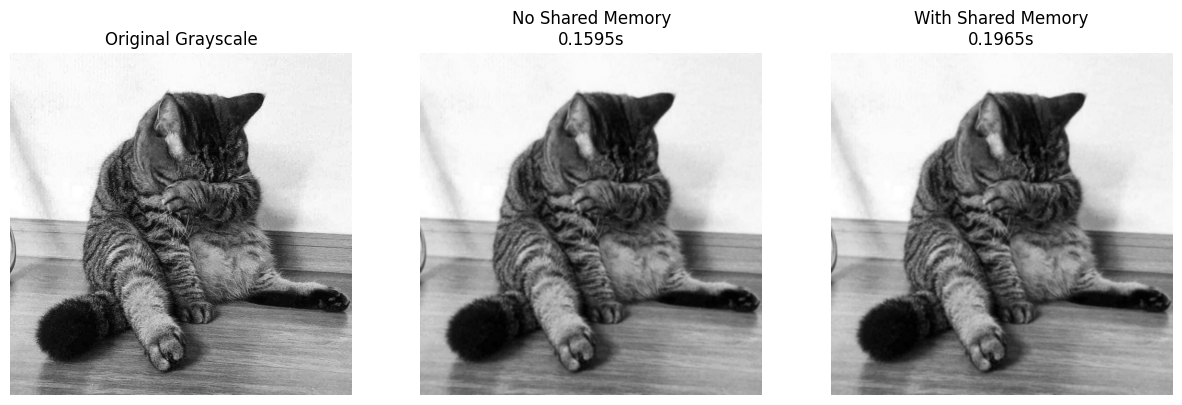

In [4]:
gray = np.mean(img, axis=2).astype(np.float32)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis("off")
plt.show()

d_src = cuda.to_device(gray)
d_dst_no_shared = cuda.device_array((h, w), dtype=np.float32)
d_dst_shared = cuda.device_array((h, w), dtype=np.float32)


gaussian_filter = np.array([
    [1, 4, 7, 10, 7, 4, 1],
    [4, 12, 26, 33, 26, 12, 4],
    [7, 26, 55, 71, 55, 26, 7],
    [10, 33, 71, 91, 71, 33, 10],
    [7, 26, 55, 71, 55, 26, 7],
    [4, 12, 26, 33, 26, 12, 4],
    [1, 4, 7, 10, 7, 4, 1]
], dtype=np.float32)
gaussian_filter /= np.sum(gaussian_filter)

d_filter = cuda.to_device(gaussian_filter)

# Kernel 1 – Without shared memory
@cuda.jit
def gaussian_no_shared(src, dst, filter):
    x, y = cuda.grid(2)
    fh, fw = filter.shape
    pad = fh // 2
    if x < src.shape[0] and y < src.shape[1]:
        acc = 0.0
        for i in range(-pad, pad + 1):
            for j in range(-pad, pad + 1):
                nx = min(max(x + i, 0), src.shape[0] - 1)
                ny = min(max(y + j, 0), src.shape[1] - 1)
                acc += src[nx, ny] * filter[i + pad, j + pad]
        dst[x, y] = acc

# Kernel 2 – With shared memory
@cuda.jit
def gaussian_shared(src, dst, filter):
    sh_filter = cuda.shared.array((7, 7), dtype=np.float32)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    x, y = cuda.grid(2)

    if tx < 7 and ty < 7:
        sh_filter[tx, ty] = filter[tx, ty]
    cuda.syncthreads()

    fh, fw = sh_filter.shape
    pad = fh // 2
    if x < src.shape[0] and y < src.shape[1]:
        acc = 0.0
        for i in range(-pad, pad + 1):
            for j in range(-pad, pad + 1):
                nx = min(max(x + i, 0), src.shape[0] - 1)
                ny = min(max(y + j, 0), src.shape[1] - 1)
                acc += src[nx, ny] * sh_filter[i + pad, j + pad]
        dst[x, y] = acc

# Run kernels and measure time
threadsperblock = (8, 8)
blockspergrid_x = (h + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (w + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

# --- No shared memory ---
start = time.time()
gaussian_no_shared[blockspergrid, threadsperblock](d_src, d_dst_no_shared, d_filter)
cuda.synchronize()
end = time.time()
time_no_shared = end - start
print(f"Gaussian Blur (no shared): {time_no_shared:.6f} seconds")

# --- With shared memory ---
start = time.time()
gaussian_shared[blockspergrid, threadsperblock](d_src, d_dst_shared, d_filter)
cuda.synchronize()
end = time.time()
time_shared = end - start
print(f"Gaussian Blur (shared): {time_shared:.6f} seconds")

print(f"Speedup: {time_no_shared / time_shared:.2f}x")

blur_no_shared = d_dst_no_shared.copy_to_host()
blur_shared = d_dst_shared.copy_to_host()

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[0].axis("off")

axs[1].imshow(blur_no_shared, cmap='gray')
axs[1].set_title(f"No Shared Memory\n{time_no_shared:.4f}s")
axs[1].axis("off")

axs[2].imshow(blur_shared, cmap='gray')
axs[2].set_title(f"With Shared Memory\n{time_shared:.4f}s")
axs[2].axis("off")

plt.show()
